# COCO dataset - Keypoints

* colab 에서 실행해본 버전입니다.  
* COCO_03_OKS.ipynb 내용에 HRNet으로 추론하는 부분 추가되었습니다.
* 런타임 유형 GPU로 먼저 바꿔놓고 코드 실행 바랍니다.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

True


In [2]:
baseDir = '/content/drive/MyDrive/ColabNotebooks/2022_SIS_TA/COCO'

In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir(baseDir)

Mounted at /content/drive


In [4]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
import cv2
import matplotlib.image as image
import json
from PIL import Image
from PIL import Image, ImageFont, ImageDraw
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [5]:
dataDir='annotations_trainval2017'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)  # coco annotation file
print(annFile)

annotations_trainval2017/annotations/instances_val2017.json


In [6]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=2.93s)
creating index...
index created!


In [7]:
catIds = coco.getCatIds(catNms=['person','snowboard'])  # 조건에 해당하는 class 번호 가져오기

In [8]:
catIds

[1, 36]

In [9]:
imgIds = coco.getImgIds(catIds=catIds)  # 해당하는 이미지 목록 가져오기
print(imgIds)

[343937, 562818, 42628, 378244, 426376, 411530, 117645, 97679, 217872, 80273, 184978, 490515, 193429, 563349, 309655, 44195, 561958, 428454, 109992, 492968, 400044, 425906, 95155, 463542, 37689, 36539, 361919, 23359, 350405, 402118, 142790, 125257, 387916, 364884, 341719, 94944, 407650, 451043, 447465, 74860, 456303, 326128, 89078, 516601, 491130, 470779, 393469, 97278]


In [10]:
idx = 0
print(imgIds[idx])  # 이미지 하나 불러오기

343937


In [11]:
img = coco.loadImgs(imgIds)[0]

In [12]:
img

{'coco_url': 'http://images.cocodataset.org/val2017/000000343937.jpg',
 'date_captured': '2013-11-20 12:55:34',
 'file_name': '000000343937.jpg',
 'flickr_url': 'http://farm5.staticflickr.com/4072/4320314557_bfcc972543_z.jpg',
 'height': 428,
 'id': 343937,
 'license': 4,
 'width': 640}

In [13]:
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType) # coco keypoint file
print(annFile)

annotations_trainval2017/annotations/person_keypoints_val2017.json


In [14]:
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=1.33s)
creating index...
index created!


In [15]:
annIds = coco_kps.getAnnIds(imgIds=img['id'], iscrowd=None)
print(annIds)  # 불러온 이미지에 해당하는 annotation 불러오기

[425370]


In [16]:
anns = coco_kps.loadAnns(annIds)

In [17]:
image_id = anns[0]['image_id']
print(image_id)

343937


In [18]:
person_id = 0
true_bbox = anns[person_id]['bbox']
print('gt_bbox : {}'.format(true_bbox))

gt_bbox : [275.07, 15.23, 134.66, 394.34]


In [19]:
print(anns[0]['keypoints'])

[290, 69, 2, 300, 57, 2, 285, 57, 2, 315, 62, 2, 0, 0, 0, 333, 97, 2, 298, 106, 2, 350, 143, 2, 0, 0, 0, 353, 198, 2, 0, 0, 0, 336, 205, 2, 317, 209, 2, 344, 291, 2, 340, 278, 2, 378, 371, 2, 374, 363, 2]


In [20]:
true_keypoint = np.array(anns[0]['keypoints'])
tx = true_keypoint[0::3]; ty = true_keypoint[1::3]; tv = true_keypoint[2::3]
print("xg shape {} {}\nyg shape {} {}\nvg shape {} {}\n".format(
    tx.shape, tx, ty.shape,ty, tv.shape,tv))

xg shape (17,) [290 300 285 315   0 333 298 350   0 353   0 336 317 344 340 378 374]
yg shape (17,) [ 69  57  57  62   0  97 106 143   0 198   0 205 209 291 278 371 363]
vg shape (17,) [2 2 2 2 0 2 2 2 0 2 0 2 2 2 2 2 2]



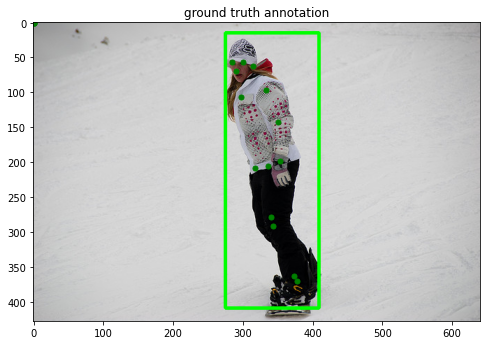

In [21]:
image = io.imread(img['coco_url'])
cv2.rectangle(image, 
              (int(true_bbox[0]), int(true_bbox[1])),
              (int(true_bbox[0])+int(true_bbox[2]), int(true_bbox[1])+int(true_bbox[3])),  #bbox 그리기
              (0,255,0), 4)
plt.plot(tx, ty, 'g.', markersize=10)  #keypoint 찍기
plt.imshow(image)
plt.title('ground truth annotation')
plt.show()

In [22]:
# plt.imshow(image)
# coco_kps.showAnns(anns)

# HRNet - Keypoints Inference

In [22]:
baseDir2 = '{}/simple-HRNet'.format(baseDir)

In [23]:
%cd $baseDir2

/content/drive/MyDrive/ColabNotebooks/2022_SIS_TA/COCO/simple-HRNet


In [24]:
!pwd

/content/drive/MyDrive/ColabNotebooks/2022_SIS_TA/COCO/simple-HRNet


In [25]:
img_dir_path = '{}/images'.format(baseDir2)
json_dir_path = '{}/json_output'.format(baseDir2)

In [26]:
img_down_source = img['coco_url']
img_down_name = img_down_source.split('/')[-1].split('.')[0]

In [27]:
print(img_down_name)

000000343937


In [28]:
img_file_name = '{}/{}.jpg'.format(img_dir_path, img_down_name)   # 필요시 확장자 수정
output_file_name = '{}/{}.json'.format(json_dir_path, img_down_name) 

In [29]:
if os.path.exists(img_file_name):
    print('image file already exists')
else:
    !wget -P $img_dir_path $img_down_source  # 추론을 위한 이미지 다운로드

--2022-05-23 14:51:23--  http://images.cocodataset.org/val2017/000000343937.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.171.81
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.171.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52720 (51K) [image/jpeg]
Saving to: ‘/content/drive/MyDrive/ColabNotebooks/2022_SIS_TA/COCO/simple-HRNet/images/000000343937.jpg’

000000343937.jpg    100%[===================>]  51.48K   119KB/s    in 0.4s    

2022-05-23 14:51:24 (119 KB/s) - ‘/content/drive/MyDrive/ColabNotebooks/2022_SIS_TA/COCO/simple-HRNet/images/000000343937.jpg’ saved [52720/52720]



In [30]:
print(img_file_name)
print(output_file_name)

/content/drive/MyDrive/ColabNotebooks/2022_SIS_TA/COCO/simple-HRNet/images/000000343937.jpg
/content/drive/MyDrive/ColabNotebooks/2022_SIS_TA/COCO/simple-HRNet/json_output/000000343937.json


Text(0.5, 1.0, 'downloaded image')

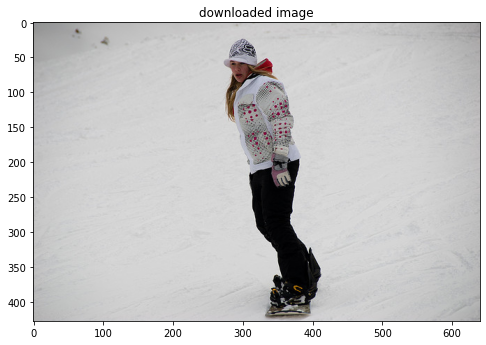

In [31]:
# 다운받은 이미지 확인하기
orign_img = cv2.imread(img_file_name)
orign_img = cv2.cvtColor(orign_img, cv2.COLOR_RGB2BGR)
plt.imshow(orign_img)
plt.title("downloaded image")

## KeyPoint 추출

In [32]:
!echo {img_file_name}

/content/drive/MyDrive/ColabNotebooks/2022_SIS_TA/COCO/simple-HRNet/images/000000343937.jpg


In [33]:
!echo {output_file_name}

/content/drive/MyDrive/ColabNotebooks/2022_SIS_TA/COCO/simple-HRNet/json_output/000000343937.json


In [34]:
!pip install ffmpeg-python

In [35]:
!python3 scripts/extract-keypoints.py \
  --filename {img_file_name} \
  --format json \
  --hrnet_weights weights/pose_hrnet_w48_384x288.pth \
  --json_output_filename {output_file_name}

device: 'cuda' - 1 GPU(s) will be used
None
number of people :  1
bbox : 
 [[193  31 489 425]]
frame:    0 / 0 - framerate: 1.589258 fps 

## 추론 가져오기

In [36]:
with open(output_file_name) as json_file:
    pred_anns = json.load(json_file)

In [37]:
pred_anns

{'0': [[[193, 31, 489, 425]],
  [[[67.9375, 291.6666564941406, 0.9739996194839478],
    [59.72916793823242, 299.8888854980469, 0.9659793376922607],
    [59.72916793823242, 287.5555419921875, 0.9892568588256836],
    [59.72916793823242, 312.22222900390625, 0.975613534450531],
    [59.72916793823242, 283.4444580078125, 0.8928779363632202],
    [92.5625, 336.8888854980469, 0.9024785161018372],
    [100.77083587646484, 291.6666564941406, 0.8426142334938049],
    [137.7083282470703, 357.4444580078125, 0.9045732617378235],
    [154.125, 304.0, 0.7554084658622742],
    [195.1666717529297, 357.4444580078125, 0.866788387298584],
    [203.375, 312.22222900390625, 0.8431138396263123],
    [203.375, 353.3333435058594, 0.8177643418312073],
    [207.4791717529297, 324.5555419921875, 0.8086429834365845],
    [285.4583435058594, 349.22222900390625, 0.8319146633148193],
    [285.4583435058594, 332.77777099609375, 0.818040132522583],
    [379.8541564941406, 382.1111145019531, 0.7681529521942139],
    [3

In [38]:
pred_anns = pred_anns['0']
pred_bbox = pred_anns[0][0]

In [39]:
pred_bbox

[193, 31, 489, 425]

In [40]:
pred_keypoint = pred_anns[1][0]
pred = np.array(pred_keypoint).reshape(-1)
px = pred[1::3]; py = pred[0::3]
print("px shape {} {}\npy shape {} {}\n".format(
    px.shape, px, py.shape, py))

px shape (17,) [291.66665649 299.8888855  287.55554199 312.222229   283.44445801
 336.8888855  291.66665649 357.44445801 304.         357.44445801
 312.222229   353.33334351 324.55554199 349.222229   332.777771
 382.1111145  394.44445801]
py shape (17,) [ 67.9375      59.72916794  59.72916794  59.72916794  59.72916794
  92.5625     100.77083588 137.70832825 154.125      195.16667175
 203.375      203.375      207.47917175 285.45834351 285.45834351
 379.85415649 347.02084351]



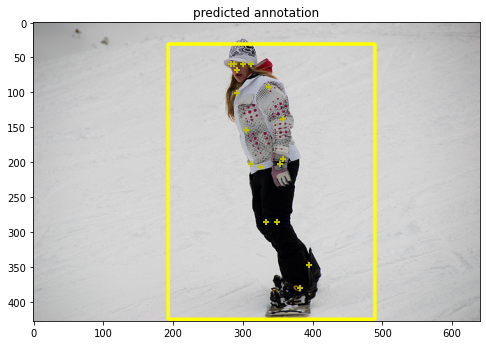

In [41]:
image = io.imread(img['coco_url'])
cv2.rectangle(image, 
              (int(pred_bbox[0]), int(pred_bbox[1])),
              (int(pred_bbox[2]), int(pred_bbox[3])),  #bbox 그리기
              (255,255,0), 4)
plt.plot(px, py, 'y+', markersize=6, markeredgewidth=2)  #keypoint 찍기
plt.title('predicted annotation')
plt.imshow(image)
plt.show()

## OKS 계산하기

$ OKS = \large \Sigma_{i}{[exp(\frac{-d^2_i}{2s^2k^2_i}\delta(v_i > 0)]/\Sigma_{i}[\delta(v_{i}>0)]}$

In [42]:
kpt_oks_sigmas = np.array(
    [.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0
sigmas = kpt_oks_sigmas
vars = (sigmas * 2)**2
k = len(sigmas)
print('k={}'.format(k))

k=17


In [43]:
x0 = true_bbox[0] - true_bbox[2]; x1 = true_bbox[0] + true_bbox[2] * 2
y0 = true_bbox[1] - true_bbox[3]; y1 = true_bbox[1] + true_bbox[3] * 2

print("true_bbox :",true_bbox)
print("tx shape {} {}\nty shape {} {}\ntv shape {} {}\n".format(
    tx.shape, tx, ty.shape,ty, tv.shape,tv))

true_bbox : [275.07, 15.23, 134.66, 394.34]
tx shape (17,) [290 300 285 315   0 333 298 350   0 353   0 336 317 344 340 378 374]
ty shape (17,) [ 69  57  57  62   0  97 106 143   0 198   0 205 209 291 278 371 363]
tv shape (17,) [2 2 2 2 0 2 2 2 0 2 0 2 2 2 2 2 2]



In [44]:
print("pred_bbox :",pred_bbox)
print("px shape {} {}\npy shape {} {}".format(
    px.shape, px, py.shape,py))

pred_bbox : [193, 31, 489, 425]
px shape (17,) [291.66665649 299.8888855  287.55554199 312.222229   283.44445801
 336.8888855  291.66665649 357.44445801 304.         357.44445801
 312.222229   353.33334351 324.55554199 349.222229   332.777771
 382.1111145  394.44445801]
py shape (17,) [ 67.9375      59.72916794  59.72916794  59.72916794  59.72916794
  92.5625     100.77083588 137.70832825 154.125      195.16667175
 203.375      203.375      207.47917175 285.45834351 285.45834351
 379.85415649 347.02084351]


In [45]:
k1 = np.count_nonzero(tv > 0)
print(k,'-->',k1)

17 --> 14


In [46]:
if k1>0:
    # measure the per-keypoint distance if keypoints visible
    dx = px - tx
    dy = py - ty
else:
    # measure minimum distance to keypoints in (x0,y0) & (x1,y1)
    z = np.zeros((k))
    dx = np.max((z, x0-px),axis=0)+np.max((z, px-x1),axis=0)
    dy = np.max((z, y0-py),axis=0)+np.max((z, py-y1),axis=0)

In [47]:
e = (dx**2 + dy**2) / vars / (anns[0]['area']+np.spacing(1)) / 2

In [48]:
e

array([2.70953678e-02, 5.59676441e-02, 1.04866809e-01, 4.92686259e-02,
       3.21148753e+02, 2.61545594e-02, 5.06756995e-02, 7.54486558e-02,
       1.05067441e+02, 3.38844965e-02, 1.69348484e+02, 1.24117987e-01,
       2.43248283e-02, 3.59160992e-02, 6.67677961e-02, 5.64076541e-02,
       3.98539923e-01])

In [49]:
if k1 > 0:
    e=e[tv > 0]   # GT의 Visibility 처리
print('e >> ',e)

e >>  [0.02709537 0.05596764 0.10486681 0.04926863 0.02615456 0.0506757
 0.07544866 0.0338845  0.12411799 0.02432483 0.0359161  0.0667678
 0.05640765 0.39853992]


In [50]:
oks = np.sum(np.exp(-e)) / e.shape[0]
print('OKS >> ',oks)

OKS >>  0.9261300706371806


## IoU 계산하기

In [51]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [52]:
true_bbox

[275.07, 15.23, 134.66, 394.34]

In [53]:
true_bbox_1 = [None] *4
true_bbox_1[0] = true_bbox[0]; true_bbox_1[1] = true_bbox[1]
true_bbox_1[2] = true_bbox[0]+true_bbox[2]; true_bbox_1[3] = true_bbox[1]+true_bbox[3]

In [54]:
true_bbox_1

[275.07, 15.23, 409.73, 409.57]

In [55]:
pred_bbox

[193, 31, 489, 425]

In [56]:
iou = IoU(true_bbox_1, pred_bbox)
print('IoU >> ', iou)

IoU >>  0.43106393919749014


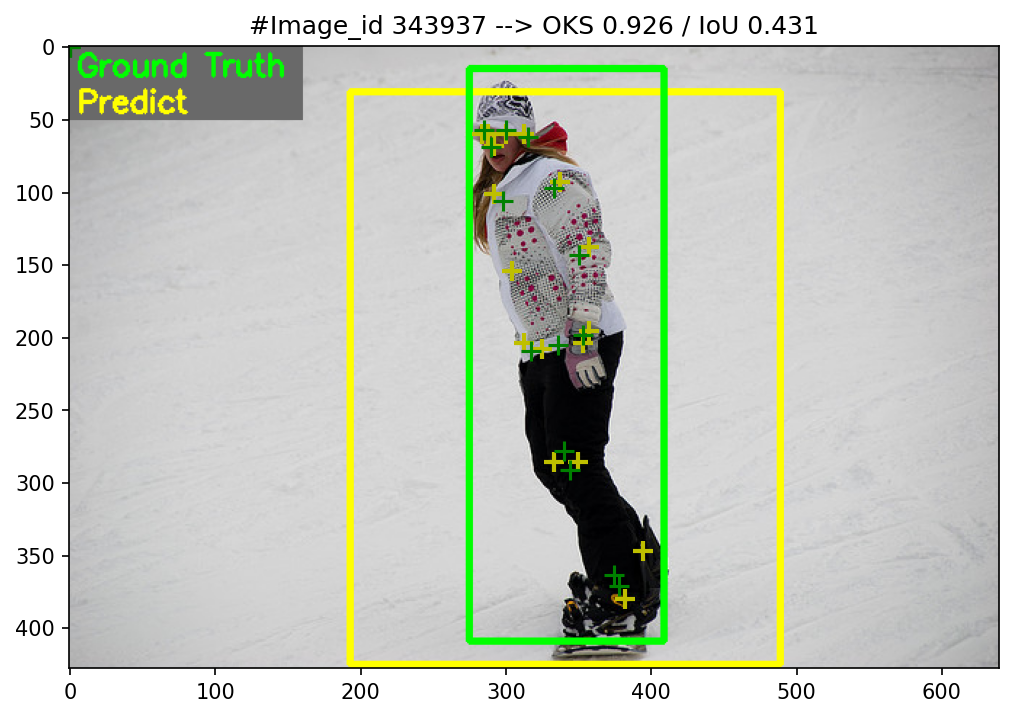

In [57]:
fig = plt.figure(dpi = 150)
cv2.rectangle(image, 
              (int(true_bbox[0]), int(true_bbox[1])),
              (int(true_bbox[0])+int(true_bbox[2]), int(true_bbox[1])+int(true_bbox[3])),
              (0,255,0), 4)

plt.plot(px, py, 'y+', markersize=10, markeredgewidth=2)
plt.plot(tx, ty, 'g+', markersize=10, markeredgewidth=1.5)  #markerfacecolor=1
plt.title('#Image_id {} --> OKS {} / IoU {}'.format(image_id, round(oks, 3), round(iou, 3)))

cv2.rectangle(image, (0, 0), (160, 50), (105,105,105), -1)  #(0,0,0) -> black
cv2.putText(image, 'Ground Truth', (5,20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
cv2.putText(image, 'Predict', (5,45), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

plt.imshow(image)
plt.show()